# Natural Language Processing

### Libraries

In [1]:
# import libraries

import nltk
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

from utils import load_filtered_data

nltk.download('stopwords')
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

from scipy import stats


[nltk_data] Downloading package stopwords to /home/bruna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/bruna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# major variables

city = 'St. Louis'
data = load_filtered_data(city)

### Preprocessing

In [3]:
# review data

data['review'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63451 entries, 0 to 63450
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    63451 non-null  object
 1   user_id      63451 non-null  object
 2   business_id  63451 non-null  object
 3   stars        63451 non-null  int64 
 4   useful       63451 non-null  int64 
 5   funny        63451 non-null  int64 
 6   cool         63451 non-null  int64 
 7   text         63451 non-null  object
 8   date         63451 non-null  object
dtypes: int64(4), object(5)
memory usage: 4.4+ MB


In [4]:
# dataframe with reviews and sentiment labels (based on stars)

reviews = data['review'].copy()

low_threshold = 2
high_threshold = 4

reviews['positive'] = reviews['stars'].apply(lambda x: 1 if x >= high_threshold else 0)
reviews['neutral'] = reviews['stars'].apply(lambda x: 1 if x < high_threshold and x > low_threshold else 0)
reviews['negative'] = reviews['stars'].apply(lambda x: 1 if x <= low_threshold else 0)

review_df = reviews[['review_id', 'text', 'positive', 'neutral', 'negative']]

review_df

,review_id,text,positive,neutral,negative
0,NvusujU9_5pIUbn9SZ6hMA,Stopped by to munch a burger during today's Se...,1,0,0
1,vHOeBa7aMA_na4rfS2Db5A,"Yelp doesn't allow to leave 0 star review, so ...",0,0,1
2,hG9RTxxivb0ZXzEk4JXTXA,I find it hard to believe there are so many pe...,0,0,1
3,zIVkwgahZjOneChZFUYY4g,Love this place! Almost all of their menu item...,1,0,0
4,DLczAuvMAlAnY5EeDGhTVg,Excellent customer service. I wish I could ren...,1,0,0
...,...,...,...,...,...
63446,OgoBp7fbXnLSKvsQb4O_tw,"I really loved the food and service. I mean, t...",1,0,0
63447,Q7e8EtZMmdknDrQE7huMoQ,Their Grove location was the bomb. Delicious f...,1,0,0
63448,zzMW6zbsFaQMjoGu2bGVdA,A nice ean BBQ joint right across from some ne...,1,0,0
63449,scgoa60EvhW2Mz7JMqLYGw,The perfect Hookah bar. I'm not sure what they...,1,0,0


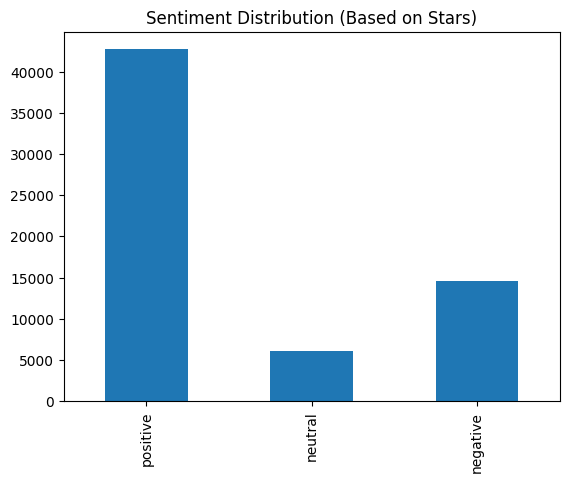

In [5]:
# distribution of sentiment labels

review_df[['positive', 'neutral', 'negative']].sum().plot(kind='bar')
plt.title('Sentiment Distribution (Based on Stars)')
plt.show()

### Cleanup and normalization

In [6]:
# see content of reviews

for review in review_df['text'].head(5).values:
    print('-' * 50)
    print(review)

--------------------------------------------------
Stopped by to munch a burger during today's Seahawks/Saints game, and the place was, unsurprisingly, packed. For good reason, too: the Haven burger I ordered was fantastic.

I sat right next to the door, so I didn't get the chance to get more than six feet into the place; as soon as I got my meal, the place started getting busier and busier until I had to work my way through the World's Shortest People Maze to get out. Guess that means I wasn't the first person to hear about the place.

I will be going back to the Haven. Might go for, say lunch on a Tuesday, so it's less busy.
--------------------------------------------------
Yelp doesn't allow to leave 0 star review, so that is why you see one star. Me and my wife are moving from NY to South California, and we contacted 5 different moving companies. I sent my initial email to United Van Lines on 05/02/2018, and soon I got email back with Virtual Survey confirmation for 05/10. The lad

In [7]:
def process_review(text, ps, sw):
    '''
    Process a review text by removing non-alphabetic characters, converting to lowercase, removing stopwords, and stemming
    '''
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in sw]
    words = [ps.stem(word) for word in words]
    text = ' '.join(words)
    return text

In [8]:
# text preprocessing

corpus = []
corpus_positive = []
corpus_neutral = []
corpus_negative = []

ps = PorterStemmer()
sw = set(stopwords.words('english'))

for i in range(0, review_df['text'].size):
    review = process_review(review_df['text'][i], ps, sw)
    corpus.append(review)
    if review_df['positive'][i] == 1:
        corpus_positive.append(review)
    elif review_df['neutral'][i] == 1:
        corpus_neutral.append(review)
    elif review_df['negative'][i] == 1:
        corpus_negative.append(review)

In [9]:
# see content of processed reviews

for review in corpus[:5]:
    print('-' * 50)
    print(review)

--------------------------------------------------
stop munch burger today seahawk saint game place unsurprisingli pack good reason burger order fantast sat right next door get chanc get six feet place soon got meal place start get busier busier work way world shortest peopl maze get guess mean first person hear place go back might go say lunch tuesday less busi
--------------------------------------------------
yelp allow leav star review see one star wife move ny south california contact differ move compani sent initi email unit van line soon got email back virtual survey confirm ladi virtual survey meticul profession screen whole apart minut one contact sent second email almost month ask everyth ok get quot need mention compani sent quot less hour sinc one repli til today call direct phone left messag answer machin one call back hope everyth ok one hurt see reason explan avoid unprofession
--------------------------------------------------
find hard believ mani peopl low standard co

### Embeddings

#### Dense Embeddings

In [10]:

def text_to_vector(embeddings, text, sequence_len):
    
    # split text into tokens
    tokens = text.split()
    
    # convert tokens to embedding vectors, up to sequence_len tokens
    vec = []
    n = 0
    i = 0
    while i < len(tokens) and n < sequence_len:   # while there are tokens and did not reach desired sequence length
        try:
            vec.extend(embeddings.get_vector(tokens[i]))
            n += 1
        except KeyError:
            True   # simply ignore out-of-vocabulary tokens
        finally:
            i += 1
    
    # add blanks up to sequence_len, if needed
    for j in range(sequence_len - n):
        vec.extend(np.zeros(embeddings.vector_size,))
    
    return vec

In [11]:

# Tokenize your preprocessed corpus
tokenized_corpus = [word_tokenize(review) for review in corpus]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

In [12]:
lens = [len(c.split()) for c in corpus]
print(np.min(lens), np.max(lens), np.mean(lens), np.std(lens), stats.mode(lens))

1 488 53.2330302122898 48.55774698364295 ModeResult(mode=13, count=1267)


In [13]:
embeddings_corpus = []
for c in corpus:
    embeddings_corpus.append(text_to_vector(word2vec_model.wv, c, 10))

In [14]:

X = np.array(embeddings_corpus)
y = reviews['positive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.60      0.66      4218
           1       0.82      0.89      0.85      8473

    accuracy                           0.79     12691
   macro avg       0.77      0.74      0.75     12691
weighted avg       0.79      0.79      0.79     12691



#### Sparse Embeddings

In [15]:

# Convert word vectors to features using TF-IDF
# count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(corpus)

y = review_df['positive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
#nb_classifier = MultinomialNB()
nb_classifier = LogisticRegression(max_iter=1000)
#nb_classifier = ComplementNB()
nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

print("Classification report:")
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      4218
           1       0.92      0.95      0.93      8473

    accuracy                           0.91     12691
   macro avg       0.90      0.89      0.90     12691
weighted avg       0.91      0.91      0.91     12691



### Wordclouds

In [16]:
# global word cloud

wordcloud = WordCloud().generate(" ".join(corpus))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

ValueError: Only supported for TrueType fonts

In [ ]:
# word cloud for positive reviews

wordcloud = WordCloud().generate(" ".join(corpus_positive))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

: 

In [ ]:
# word cloud for neutral reviews

wordcloud = WordCloud().generate(" ".join(corpus_neutral))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

: 

In [ ]:
# word cloud for negative reviews

wordcloud = WordCloud().generate(" ".join(corpus_negative))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

: 

### Frequency Distributions

In [ ]:
# frequency distribution of words

all_words = ' '.join(corpus).split()
fd = nltk.FreqDist(all_words)

positive_words = ' '.join(corpus_positive).split()
fd_positive = nltk.FreqDist(positive_words)

neutral_words = ' '.join(corpus_neutral).split()
fd_neutral = nltk.FreqDist(neutral_words)

negative_words = ' '.join(corpus_negative).split()
fd_negative = nltk.FreqDist(negative_words)

: 

In [ ]:
# most common words in reviews

fd.most_common(5)

: 

In [ ]:
# most common words in positive reviews

fd_positive.most_common(10)

: 

In [ ]:
# most common words in neutral reviews

fd_neutral.most_common(10)

: 

In [ ]:
# most common words in negative reviews

fd_negative.most_common(10)

: 

In [ ]:
# TODO

: 